# A look at winds & SWH data in link with land topography #

Winds are blowing over continents & islands, but are impacted by reliefs and this can be seen in ocean altimetry data

<br>made for Eumetsat Copernicus Marine Data Service by V. Rosmorduc, CLS

** Import libraries **

In [1]:
import os
import numpy
# reading / using NetCDF data
import xarray
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# these are valid for all the data below
# name of the storm to access the data folder
storm = 'Gerard'
#area 
lon_min = 0; lon_max = 5; lat_min = 35; lat_max = 45

#data folder
#input_root = 'data'+ '/' + storm
input_root = 'data'


## Plot waves and winds from altimetry ##

In [2]:
#upload files 
#fill in the data folder name
input_path = 'S3B_SR_2_WAT____20230118T100419_20230118T105202_20230120T020120_2863_075_122______MAR_O_ST_005'
#the reduced file is more than enough for our needs here. 
input_file = 'reduced_measurement.nc'

my_file = os.path.join(input_root,input_path,input_file)
ncalti = xarray.open_dataset(my_file)

C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


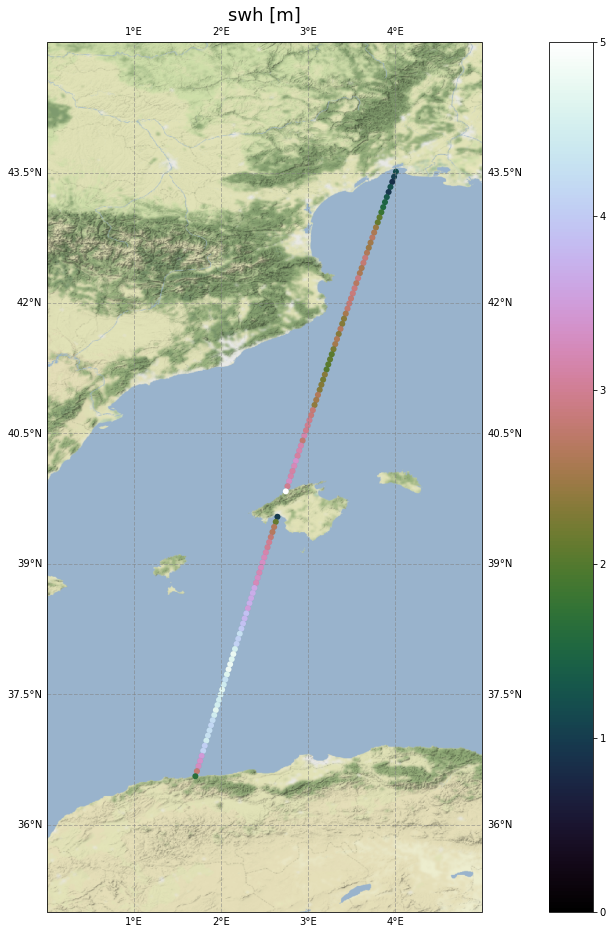

In [5]:
# load the data ; we take the Significant Wave Height field at 1 Hz in Ku band, over ocean surfaces.
lat = ncalti['lat_01']
lon = ncalti['lon_01']
swh = ncalti.variables['swh_ocean_01_ku']
lat = lat[ ncalti['surf_class_01']==0 ]
lon = lon[ ncalti['surf_class_01']==0 ]
swh = swh[ ncalti['surf_class_01']==0 ]

#plot it on a map
fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='lightgrey')
#ax.add_feature(cartopy.feature.BORDERS)

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tiler = cimgt.Stamen('terrain-background')
zoom = 8
ax.add_image(tiler, zoom)


# actually plot the data
tracks = ax.scatter(lon, lat, c=swh,  vmin=0, vmax=5, cmap='cubehelix', marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
plt.title('swh [m]', size=18)
plt.show()

C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


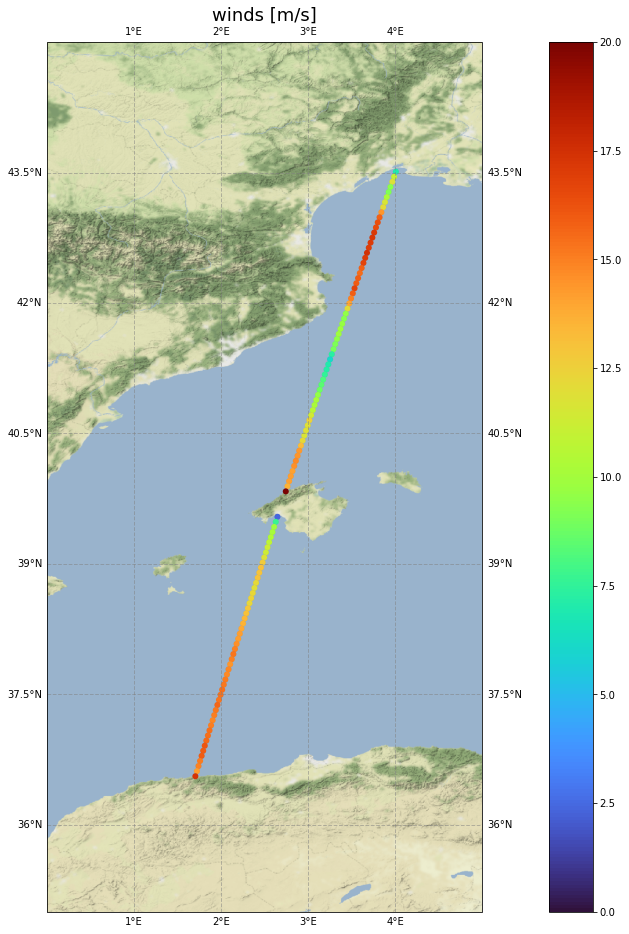

In [6]:
# load the data ; we take the Significant Wave Height field at 1 Hz in Ku band
winds = ncalti.variables['wind_speed_alt_01_ku']
winds = winds[ ncalti['surf_class_01']==0 ]

#plot it on a map
fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tiler = cimgt.Stamen('terrain-background')
zoom = 8
ax.add_image(tiler, zoom)
# actually plot the data
tracks = ax.scatter(lon, lat, c=winds,  vmin=0, vmax=20, cmap='turbo', marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
plt.title('winds [m/s]', size=18)
plt.show()
ncalti.close()

Plot along the latitude only, to have another look at the dynamic of the wave heights. 

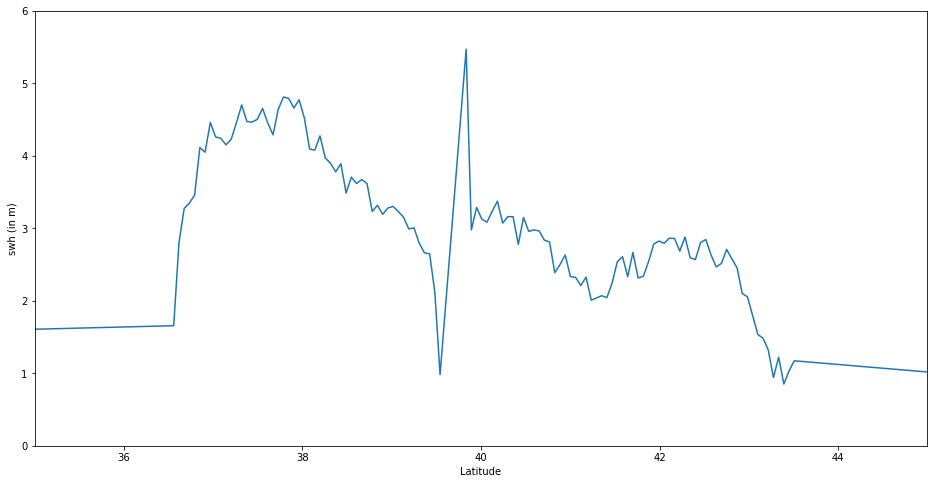

In [18]:
fig = plt.figure(figsize=(16,8))
plt.ylabel('swh (in m)')
plt.xlabel('Latitude')
plt.axis([lat_min, lat_max, 0, 6])
plt.plot(lat, swh)

Plot also the winds along the latitude only

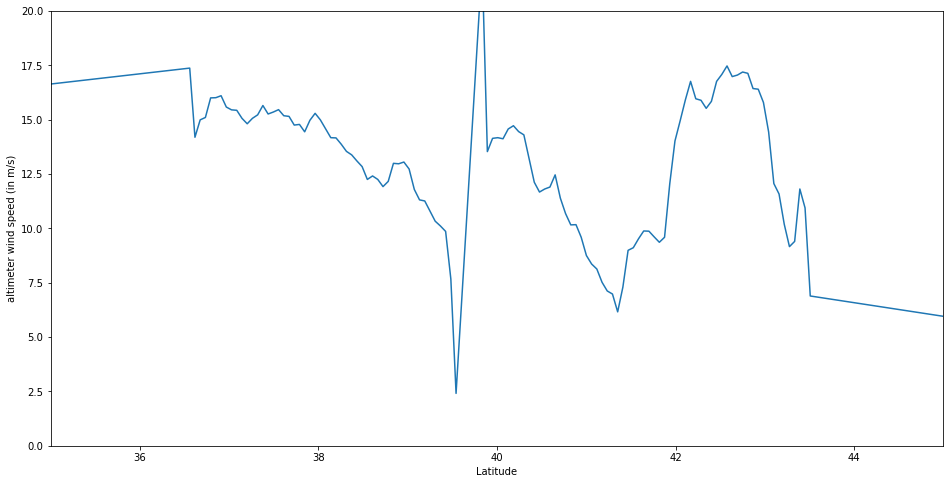

In [14]:
fig = plt.figure(figsize=(16,8))
plt.ylabel('altimeter wind speed (in m/s)')
plt.xlabel('Latitude')
plt.axis([lat_min, lat_max, 0, 20])
plt.plot(lat, winds)

## SAR wind data ##
Extreme winds data are available through www.esa-cyms.org (on the ftp data access).

SAR data at 5:53 UTC, alti data at about 10:20 UTC (file from 10:04 to 10:52), so more than 4 hours after -- winds had time to change.

Text(0.5, 1.0, 'wind speed [m/s]')

C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\vrosmorduc.GROUPCLS\Anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


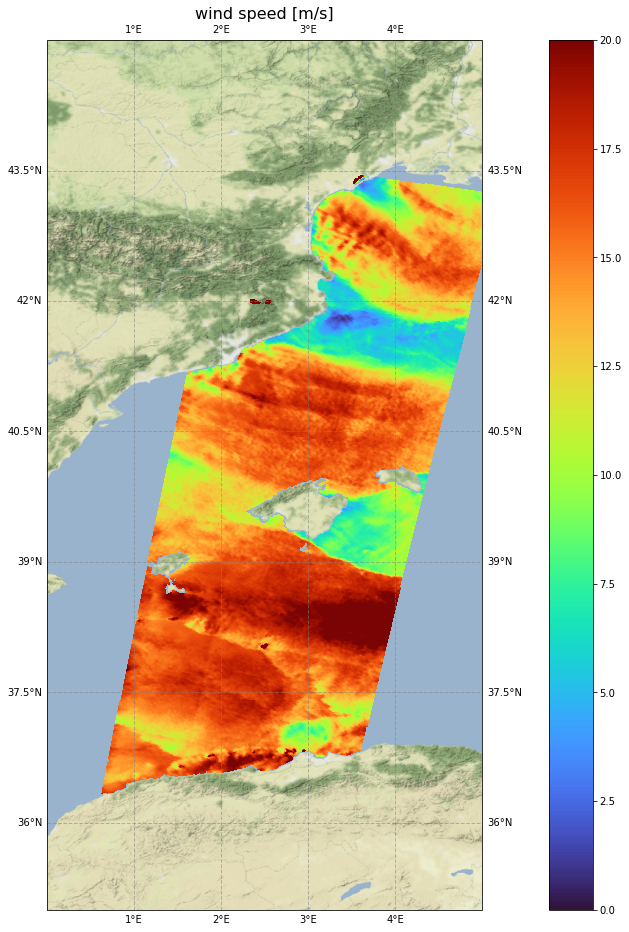

In [12]:
sar_file = 'data/s1a-iw-owi-cm-20230118t055303-20230118t055508-000003-046834_gs.nc'

#plot it on a map
fig = plt.figure(figsize=(24,16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tiler = cimgt.Stamen('terrain-background')
zoom = 8
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor='lightgrey')
ax.add_image(tiler, zoom)

ncsar = xarray.load_dataset(sar_file)
latsar = ncsar.variables['latitude'][0]
lonsar = ncsar.variables['longitude'][0]
windsar = ncsar.variables['wind_speed'][0]
mymap = ax.pcolor(lonsar, latsar, windsar, vmin=0, vmax=20, cmap='turbo')
tracks = ax.scatter(lon, lat, c=winds,  vmin=0, vmax=20, cmap='turbo', marker='o', edgecolors='black', linewidth=0.1)
ncsar.close()

# add colorbar
cbar = plt.colorbar(mymap)
plt.title('wind speed [m/s]', size=16)